In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import io
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets

from PIL import Image
from warnings import filterwarnings

from IPython.display import display, clear_output

What is tqdm?



tqdm is a Python library that allows you to output a smart progress bar by wrapping around any iterable.

A tqdm progress bar not only shows you how much time has elapsed, but also shows the estimated time remaining for the iterable.

Resulting tqdm progress bar gives us information that includes the task completion percentage, number of iterations complete, time elapsed, estimated time remaining, and the iterations completed per second.

In [6]:
labels=['Cu1','Cu2','Cu4','Cu8','Cu16','Cu32','Cu64','Cu128','Cu256','Cu512','Cu1024']

In [7]:
X_train=[]
Y_train=[]

image_size=150

for i in labels:
    folderpath=os.path.join("../input/countingforlaser/Num_Radiation/","new_2^n_train",i)
    for j in tqdm(os.listdir(folderpath)):
        image=cv2.imread(os.path.join(folderpath,j))
        image=cv2.resize(image, (image_size,image_size))
        
        X_train.append(image)
        Y_train.append(i)
        

        
for i in labels:
    folderpath=os.path.join("../input/countingforlaser/Num_Radiation/","new_2^n_test",i)
    for j in tqdm(os.listdir(folderpath)):
        image=cv2.imread(os.path.join(folderpath,j))
        image=cv2.resize(image, (image_size,image_size))
        
        X_train.append(image)
        Y_train.append(i)
        
        
X_train=np.array(X_train)
Y_train=np.array(Y_train)
        




In [8]:
X_train.shape

In [9]:
Y_train

In [10]:
X_train,Y_train=shuffle(X_train, Y_train, random_state=42)

In [11]:
X_train,X_test,Y_train, Y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [12]:
X_train.shape

In [13]:
Y_train[1500]

In [14]:
Y_test.shape

In [15]:
y_train_new=[]
y_test_new=[]

for i in Y_train:
    y_train_new.append(labels.index(i))
    
Y_train=y_train_new
Y_train=to_categorical(Y_train)

for i in Y_test:
    y_test_new.append(labels.index(i))
    
Y_test=y_test_new
Y_test=to_categorical(Y_test)


In [16]:
Y_train

In [17]:
np.argmax(Y_train[40])

EfficientNetB5( include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation="softmax", **kwargs )


In [18]:
efficient=EfficientNetB4(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))

In [19]:
model=efficient.output
model=tf.keras.layers.GlobalAveragePooling2D()(model)
model=tf.keras.layers.Dropout(0.5)(model)
model=tf.keras.layers.Dense (11,activation="softmax")(model)
model=tf.keras.models.Model(inputs=efficient.input, outputs=model)

In [20]:
model.summary()

In [21]:
model.compile(loss='categorical_crossentropy',
             optimizer='Adam',
              metrics=['accuracy']
             )

TensorBoard
image.png

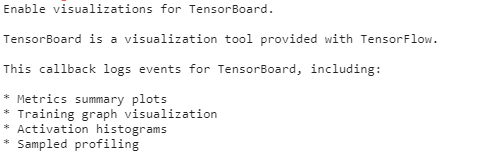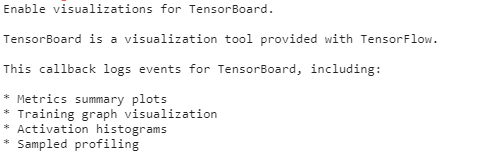

ModelCheckpoint##

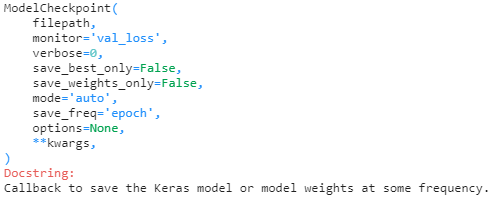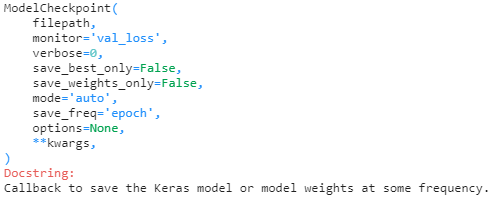

ReduceLROnPlateau

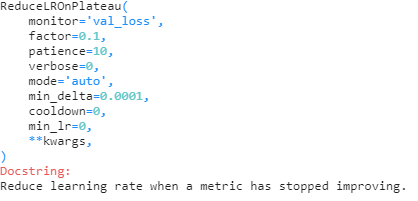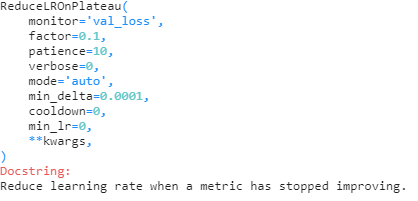

In [22]:
tensorboard=TensorBoard(log_dir="logs")
checkpoint=ModelCheckpoint("efficient.h5",
                          monitor='val_accuracy',
                          mode="auto",
                          verbose=1,
                          save_best_only=True
                          )

reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.1,
                            patience=10,
                            min_delta=0.001,
                            mode="auto",
                            verbose=1
                           )

In [23]:
history=model.fit(X_train,Y_train,
                 validation_split=0.2,
                  epochs=20,
                  verbose=1,
                  batch_size=32,
                  callbacks=[tensorboard, checkpoint,reduce_LR]
                 )

In [24]:
pred=model.predict(X_test)

In [25]:
model.evaluate(X_test,Y_test)

In [26]:
pred=np.argmax(pred,axis=1)
y_test_new=np.argmax(Y_test,axis=1)

In [27]:
print(classification_report(y_test_new,pred))

In [28]:
Cm=confusion_matrix(y_test_new,pred)
ax=plt.axes()
sns.heatmap(Cm, annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
            yticklabels=labels,
            ax=ax
           )

plt.title("Confusion Metrics for Number Of Shot Counting using Image")
plt.show()

In [29]:
def accuracy_and_loss_Plot(modelData):
    
    fig=plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    
    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    

In [30]:
accuracy_and_loss_Plot(history)

In [31]:
plt.savefig("accuracy_and_loss_Plot.png")

plot_model

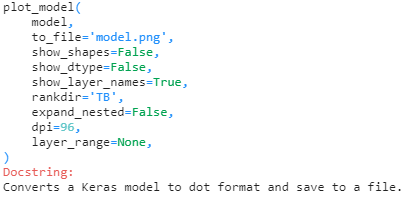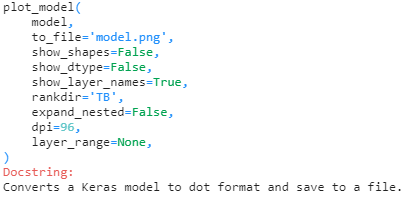

In [33]:
saved_model=tf.keras.models.load_model("./efficient.h5")

#show model architecture
plot_model(saved_model,
           to_file='efficient.png',
           show_shapes=True,
           show_layer_names=True
          )

Uploading Image and Showing its Class

In [38]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "Cu1"
    elif prd == 1:
        prd = "Cu2"
    elif prd ==2:
        prd = "Cu4"
        
    elif prd == 3:
        prd = "Cu8"
    elif prd ==4:
        prd = "Cu16"
    elif prd == 5:
        prd = "Cu32"
    elif prd ==6:
        prd = "Cu64"
    elif prd == 7:
        prd = "Cu128"
    elif prd ==8:
        prd = "Cu256"
    elif prd == 9:
        prd = "Cu512"
    elif prd ==10:
        prd = "Cu1024"
        
    print(f'Model Predict That is  a {prd}')

In [39]:
uploader = widgets.FileUpload()
display(uploader)

In [41]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])